# Machine Learning Engineer Nanodegree - 2019
## Capstone Project: Movie Box Office Revenue Prediction with Gradient Boosting Models
Author: Daniel Tejeda

In a world where movies made an estimated 41.7 billion in 2018 and expected to go over 50 billion by 2020, the film industry is more popular than ever. But which movies make the most money at the box office? How much does a director or the budget matter? In this capstone project, I will build a model to answer that question, working with metadata on over 7,000 past films from The Movie Database published as part of TMDB Box Office Prediction Kaggle competition. 


### Project Design

This project will be implemented in Python 3.7. Libraries involved will be numpy, pandas, matplotlib, seaborn, xgboost, lightgbm, catboost, scikit-learn.

The workflow for this project will be in the following order: 
0. Import all libraries
- Exploratory data analysis
- Data cleansing and Feature engineering
- Train the KNN benchmark model based on budget, popularity and runtime
- Stage-1: Boosting Models 
    * Code and train XGBoost model 
    * Code and train CATBoost model
    * Code and train LightGBM model
    * Hyperparameter tuning for the three models
    * Evaluate results against KNN and select new benchmark from the boosting models to be the new benchmark.
    
- Stage 2: Stacked final model
    * Select stacking approach and regression algorithm for the final model
    * Train regression algorithm with the outputs of the base boosting models combined with the original features, according to the stacking approach
    * Hyperparameter tuning for the final model
    * Evaluate and report final results against the benchmark 



## 0. Import all libraries

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import visuals as vs
import data_prep as dp
import json
from itertools import cycle, islice
from datetime import datetime

from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, SGDRegressor, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn import cluster

import xgboost as xgb
import lightgbm as lgb
import catboost as cat
import copy



## 1. Exploratory data analysis

In [2]:
dataset_names = ['train','test']

# load original datasets
original_datasets = { ds : pd.read_csv("data/{}.csv".format(ds)) for ds in dataset_names }

# complete missing budget/revenue values from B H's Kernel. (https://www.kaggle.com/zero92/tmdb-prediction)
dp.complete_missing_data(original_datasets)

original_datasets['train'].head(3)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


In [3]:
n_records = original_datasets['train'].shape[0]
n_columns = original_datasets['train'].shape[1]

print("Total number of records: {}".format(n_records))
print("Total number of features: {}".format(n_columns))

Total number of records: 3000
Total number of features: 23


In [4]:
original_datasets['train'].describe(include='all')

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
count,3000.000000,604,3.000000e+03,2993,946,3000,3000,3000,2992,3000.000000,...,3000,2998.000000,2980,3000,2403,3000,2724,2987,2984,3.000000e+03
unique,NaN,422,NaN,872,941,3000,36,2975,2992,NaN,...,2398,NaN,401,2,2400,2969,2648,2975,2984,NaN
top,NaN,"[{'id': 645, 'name': 'James Bond Collection', ...",NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt0037536,en,Hot Pursuit,Based on Gayle Forman's novel of the same name...,NaN,...,9/10/15,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Ghost,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '581ae882c3a3683db800184c', 'de...",NaN
freq,NaN,16,NaN,266,4,1,2575,2,1,NaN,...,5,NaN,1817,2996,3,2,27,13,1,NaN
mean,1500.500000,NaN,2.266135e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.463274,...,NaN,107.856571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.668176e+07
std,866.169729,NaN,3.702662e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.104000,...,NaN,22.086434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375149e+08
min,1.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,750.750000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.018053,...,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.401550e+06
50%,1500.500000,NaN,8.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.374861,...,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.680707e+07
75%,2250.250000,NaN,3.000000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.890983,...,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.877599e+07


Some fields contain list with dictionaries. We will need to extract and transform these features. 

 

### Missing values

In [5]:
original_datasets['train'].isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

### Distribution of target variable Revenue
Let's take a look at the target variable revenue and how its distributed. We are also plotting the Log1p, since we are going to use this in out model

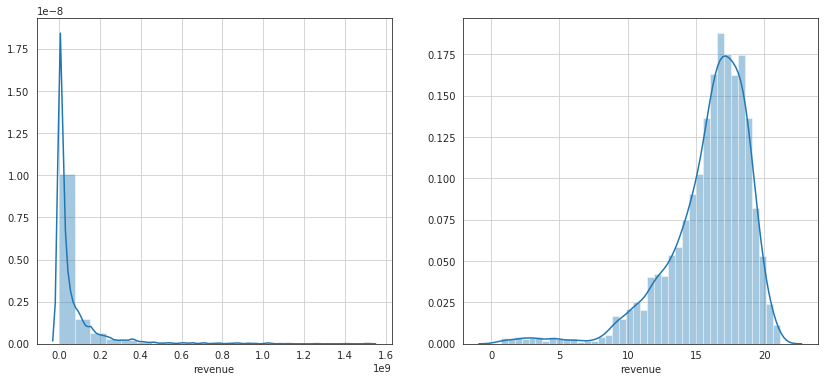

In [6]:
quant_data = original_datasets['train'].set_index('id')[['budget','popularity','runtime', 'revenue']]

sb.set_style("white")

fig, axes = plt.subplots(1, 2, figsize = (14,6))

sb.distplot(quant_data['revenue'], bins=20, kde=True, ax=axes[0])
sb.distplot(np.log1p(quant_data['revenue']), bins=40, kde=True, ax=axes[1])

for ax in axes: ax.grid()
    

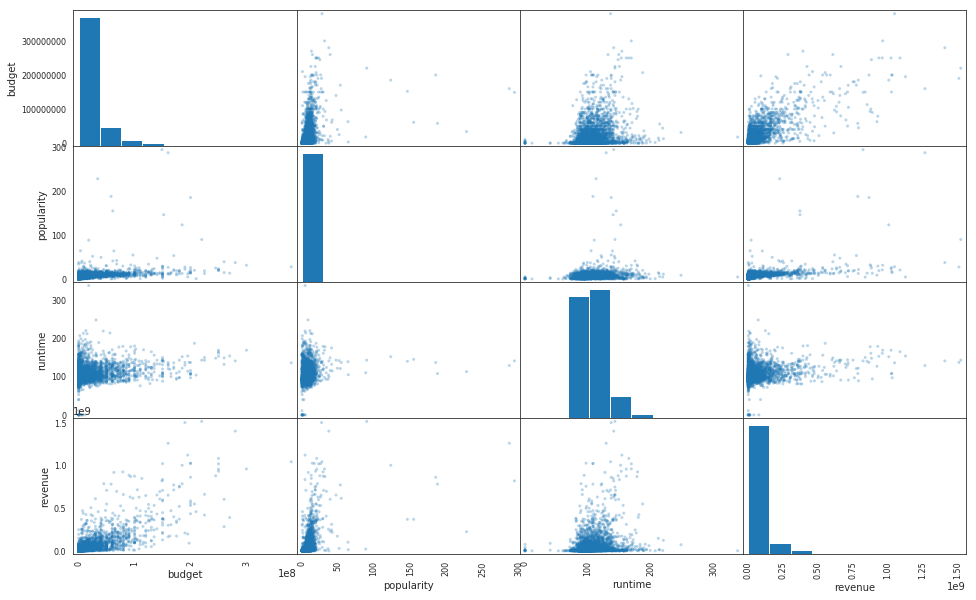

In [7]:
# scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(quant_data, alpha = 0.3, figsize = (16,10));

## 2. Data cleansing and feature engineering

In [8]:
# copy the original dataset and replace NaN with empty string
all_data = original_datasets['train'].set_index('id')

# two movies have NaN runtime, we fill those with the mean
all_data['runtime'].fillna(all_data['runtime'].mean(), inplace=True)

# replace NaN in strings
all_data.fillna('', inplace=True)

drop_feat=False

In [9]:
#let's break down month/day/year from release_date
all_data[['rel_month','rel_day','rel_year']] = all_data['release_date'].str.split('/', expand=True).astype(int)

# fix 2-digit year for 1920-1999
all_data['rel_year'] += 1900
# 2000-2019
all_data.loc[all_data['rel_year'] <= 1919, "rel_year"] += 100

# extract day of week and quarter
rel_date = pd.to_datetime(all_data['release_date']) 
all_data['rel_dow'] = rel_date.dt.dayofweek
all_data['rel_quarter'] = rel_date.dt.quarter

all_data[['rel_month','rel_day','rel_year','rel_dow','rel_quarter']].head(3)


,rel_month,rel_day,rel_year,rel_dow,rel_quarter
id,,,,,
1,2,20,2015,4,1
2,8,6,2004,4,3
3,10,10,2014,4,4


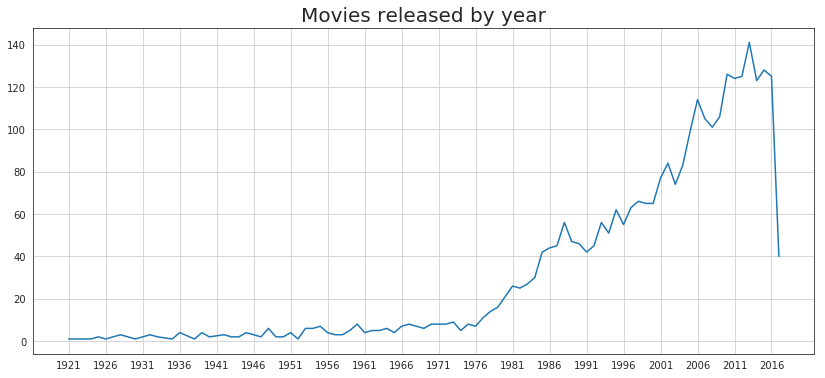

In [10]:
yr_counts = all_data['rel_year'].value_counts().sort_index()
yr_xticks = range(yr_counts.index.values[0],yr_counts.index.values[-1],5)

plt.figure(figsize = (14,6))
plt.plot(yr_counts.index.values, yr_counts.values)
plt.xticks(yr_xticks)
plt.title("Movies released by year",fontsize=20)
plt.grid()

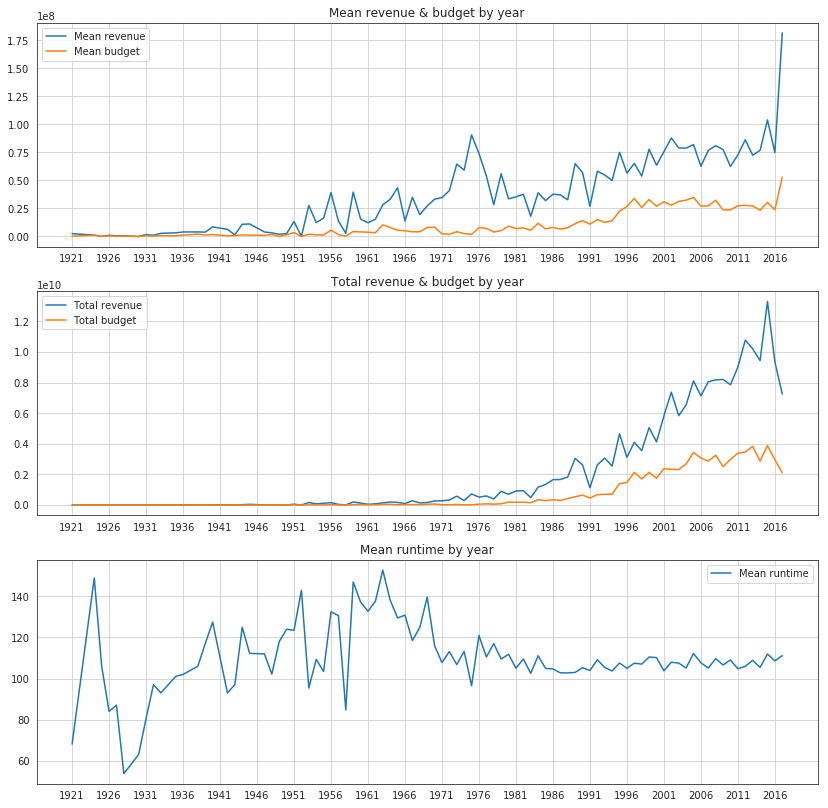

In [11]:
yr_avgs = all_data.groupby('rel_year').mean()
yr_totals = all_data.groupby('rel_year').sum()

fig, axes = plt.subplots(3, 1, figsize=(14,14))

axes[0].set_title("Mean revenue & budget by year")
axes[0].plot(yr_avgs.index.values, yr_avgs['revenue'], label='Mean revenue')
axes[0].plot(yr_avgs.index.values, yr_avgs['budget'], label='Mean budget')
axes[0].set_xticks(yr_xticks)

axes[1].set_title("Total revenue & budget by year")
axes[1].plot(yr_totals.index.values, yr_totals['revenue'], label='Total revenue')
axes[1].plot(yr_totals.index.values, yr_totals['budget'], label='Total budget')
axes[1].set_xticks(yr_xticks)

axes[2].set_title("Mean runtime by year")
axes[2].plot(yr_avgs.index.values, yr_avgs['runtime'], label='Mean runtime')
axes[2].set_xticks(yr_xticks)

for ax in axes: 
    ax.grid()
    ax.legend()

In [12]:
# belongs_to_collection
all_data['from_collection'] = all_data['belongs_to_collection'].apply(lambda x: 1 if len(x) > 0 else 0)

all_data['collection_name'] = all_data['belongs_to_collection'].map(lambda x: 'col_{}'.format(dp.get_dictionary(x)[0]['name']) if len(x) > 0 else '')

collection_names = all_data['collection_name'].str.translate({ord(i): None for i in '[]<'}).str.get_dummies()

all_data = pd.concat([all_data, collection_names], axis=1, sort=False)

print("Movies that belong to a collection: {} / {}".format(sum(all_data['from_collection']), n_records))

Movies that belong to a collection: 604 / 3000


In [13]:
collection_names.rename(lambda x:x[4:], axis='columns').sum().sort_values(ascending=False).head(20)

James Bond Collection                     16
Friday the 13th Collection                 7
The Pink Panther (Original) Collection     6
Pokémon Collection                         5
Police Academy Collection                  5
Alien Collection                           4
Rocky Collection                           4
The Fast and the Furious Collection        4
Resident Evil Collection                   4
Paranormal Activity Collection             4
Transformers Collection                    4
Child's Play Collection                    4
Ice Age Collection                         4
Rambo Collection                           4
Halloween Collection                       3
Three Heroes Collection                    3
The Vengeance Collection                   3
The Wolverine Collection                   3
REC Collection                             3
Indiana Jones Collection                   3
dtype: int64

In [14]:
#homepage
all_data['has_homepage'] = all_data['homepage'].apply(lambda x: 1 if len(x) > 0 else 0)

print("Movies with homepage: {} / {}".format(sum(all_data['has_homepage']), n_records))

Movies with homepage: 946 / 3000


In [15]:
#extract genre information from genre column
all_data['genres_new'] = all_data['genres'].map(lambda x: sorted(['genre_{}'.format(d['name']) for d in dp.get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))

#one-hot-encoding 
genres = all_data.genres_new.str.get_dummies(sep=',')

#concatenate one-hot-encoding for genres to all_data
all_data = pd.concat([all_data, genres], axis=1, sort=False)

genres.rename(lambda x:x[6:], axis='columns').sum()

Action              741
Adventure           439
Animation           141
Comedy             1028
Crime               469
Documentary          87
Drama              1531
Family              260
Fantasy             232
Foreign              31
History             132
Horror              301
Music               100
Mystery             225
Romance             571
Science Fiction     290
TV Movie              1
Thriller            789
War                 100
Western              43
dtype: int64

In [16]:
all_data['crew_g0'] = all_data['crew'].apply(lambda x: sum([1 for i in dp.get_dictionary(x) if i['gender'] == 0]))
all_data['crew_g1'] = all_data['crew'].apply(lambda x: sum([1 for i in dp.get_dictionary(x) if i['gender'] == 1]))
all_data['crew_g2'] = all_data['crew'].apply(lambda x: sum([1 for i in dp.get_dictionary(x) if i['gender'] == 2]))
all_data['crew_cnt'] = all_data['crew_g0'] + all_data['crew_g1'] + all_data['crew_g2']  
#TODO: more with crew

all_data[['crew_g0', 'crew_g1', 'crew_g2', 'crew_cnt']].head()

,crew_g0,crew_g1,crew_g2,crew_cnt
id,,,,
1,59,0,13,72
2,1,4,4,9
3,49,4,11,64
4,3,0,0,3
5,2,0,0,2


In [17]:
#all_data['cast_cnt'] = all_data['cast'].apply(lambda x: len(x) if x != {} else 0)

all_data['cast_g0'] = all_data['cast'].apply(lambda x: sum([1 for i in dp.get_dictionary(x) if i['gender'] == 0]))
all_data['cast_g1'] = all_data['cast'].apply(lambda x: sum([1 for i in dp.get_dictionary(x) if i['gender'] == 1]))
all_data['cast_g2'] = all_data['cast'].apply(lambda x: sum([1 for i in dp.get_dictionary(x) if i['gender'] == 2]))

all_data['cast_cnt'] = all_data['cast_g0'] + all_data['cast_g1']+all_data['cast_g2']

#TODO: more with cast

all_data[['cast_g0', 'cast_g1', 'cast_g2', 'cast_cnt']].head()

,cast_g0,cast_g1,cast_g2,cast_cnt
id,,,,
1,6,8,10,24
2,0,10,10,20
3,31,7,13,51
4,4,1,2,7
5,0,0,4,4


In [18]:
original_langs = pd.get_dummies(all_data['original_language'], prefix='lang_')

all_data = pd.concat([all_data, original_langs], axis=1, sort=False)

In [47]:
#extract production company information from genre column
all_data['production_companies_new'] = all_data['production_companies'].map(lambda x: sorted(['prodc_{}'.format(d['name'].strip()) for d in dp.get_dictionary(x)])).map(lambda x: '|'.join(map(str, x)))

#one-hot-encoding 
prodcs = all_data.production_companies_new.str.get_dummies(sep='|')

#concatenate one-hot-encoding for genres to all_data
all_data = pd.concat([all_data, prodcs], axis=1, sort=False)

#prodcs.rename(lambda x:x[6:], axis='columns').sum()
prodcs.rename(lambda x:x[6:], axis='columns').sum().sort_values(ascending=False).head(30)

Warner Bros.                              202
Universal Pictures                        188
Paramount Pictures                        161
Twentieth Century Fox Film Corporation    138
Columbia Pictures                          91
Metro-Goldwyn-Mayer (MGM)                  84
New Line Cinema                            75
Touchstone Pictures                        63
Walt Disney Pictures                       62
Columbia Pictures Corporation              61
TriStar Pictures                           53
Relativity Media                           48
Canal+                                     46
United Artists                             44
Miramax Films                              40
Village Roadshow Pictures                  36
Regency Enterprises                        31
Dune Entertainment                         30
Working Title Films                        30
BBC Films                                  30
Fox Searchlight Pictures                   29
StudioCanal                       

In [19]:
#convert quantities to log 
all_data[['log_budget','log_popularity','log_runtime']] = np.log1p(all_data[['budget','popularity','runtime']])

#all_data['revenue'] = np.log1p(all_data['revenue'])

# remove original columns
drop_cols = ['release_date', 
             'belongs_to_collection', 
             'collection_name',
             'homepage', 
             'genres',
             'genres_new',
             'crew',
             'cast',
             'original_language',
             
             'original_title',
             'overview',
             'production_companies',
             'production_companies_new',
             'production_countries',
             'spoken_languages',
             'tagline',
             'title',
             'Keywords',
             'status',
             
             'imdb_id',
             'poster_path',
             
             'budget',
             'popularity',
             'runtime'
             
            ]

all_data.drop(drop_cols, axis=1, inplace=True);


In [491]:
def prepare_data(in_data):
    
    #copy
    data = in_data.set_index('id')

    # two movies have NaN runtime, we fill those with the mean
    data['runtime'].fillna(data['runtime'].mean(), inplace=True)

    # replace NaN in strings
    data.fillna('', inplace=True)

    #let's break down month/day/year from release_date
    data[['rel_month','rel_day','rel_year']] = data['release_date'].str.split('/', expand=True).astype(int)

    # fix 2-digit year for 1920-1999
    data['rel_year'] += 1900
    # 2000-2019
    data.loc[data['rel_year'] <= 1919, "rel_year"] += 100

    # extract day of week and quarter
    rel_date = pd.to_datetime(data['release_date']) 
    data['rel_dow'] = rel_date.dt.dayofweek
    data['rel_quarter'] = rel_date.dt.quarter

    data[['rel_month','rel_day','rel_year','rel_dow','rel_quarter']].head(3)


    # belongs_to_collection
    data['from_collection'] = data['belongs_to_collection'].apply(lambda x: 1 if len(x) > 0 else 0)
    data['collection_name'] = data['belongs_to_collection'].map(lambda x: 'col_{}'.format(dp.get_dictionary(x)[0]['name']) if len(x) > 0 else '')
    collection_names = data['collection_name'].str.translate({ord(i): None for i in '[]<'}).str.get_dummies()

    data = pd.concat([data, collection_names], axis=1, sort=False)
    #homepage
    data['has_homepage'] = data['homepage'].apply(lambda x: 1 if len(x) > 0 else 0)

    #extract genre information from genre column
    data['genres_new'] = data['genres'].map(lambda x: sorted(['genre_{}'.format(d['name']) for d in dp.get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))

    #one-hot-encoding 
    genres = data.genres_new.str.get_dummies(sep=',')

    #concatenate one-hot-encoding for genres to data
    data = pd.concat([data, genres], axis=1, sort=False)

    genres.rename(lambda x:x[6:], axis='columns').sum()

    data['crew_g0'] = data['crew'].apply(lambda x: sum([1 for i in dp.get_dictionary(x) if i['gender'] == 0]))
    data['crew_g1'] = data['crew'].apply(lambda x: sum([1 for i in dp.get_dictionary(x) if i['gender'] == 1]))
    data['crew_g2'] = data['crew'].apply(lambda x: sum([1 for i in dp.get_dictionary(x) if i['gender'] == 2]))
    data['crew_cnt'] = data['crew_g0'] + data['crew_g1'] + data['crew_g2']  
    #TODO: more with crew

    data[['crew_g0', 'crew_g1', 'crew_g2', 'crew_cnt']].head()

   
    data['cast_g0'] = data['cast'].apply(lambda x: sum([1 for i in dp.get_dictionary(x) if i['gender'] == 0]))
    data['cast_g1'] = data['cast'].apply(lambda x: sum([1 for i in dp.get_dictionary(x) if i['gender'] == 1]))
    data['cast_g2'] = data['cast'].apply(lambda x: sum([1 for i in dp.get_dictionary(x) if i['gender'] == 2]))

    data['cast_cnt'] = data['cast_g0'] + data['cast_g1']+data['cast_g2']

    #TODO: more with cast

    data[['cast_g0', 'cast_g1', 'cast_g2', 'cast_cnt']].head()

    original_langs = pd.get_dummies(data['original_language'], prefix='lang_')
    data = pd.concat([data, original_langs], axis=1, sort=False)

    #convert quantities to log 
    data[['log_budget','log_popularity','log_runtime']] = np.log1p(data[['budget','popularity','runtime']])

    # remove original columns
    drop_cols = ['release_date', 
                 'belongs_to_collection', 
                 'collection_name',
                 'homepage', 
                 'genres',
                 'genres_new',
                 'crew',
                 'cast',
                 'original_language',

                 'original_title',
                 'overview',
                 'production_companies',
                 'production_countries',
                 'spoken_languages',
                 'tagline',
                 'title',
                 'Keywords',
                 'status',

                 'imdb_id',
                 'poster_path',

                 'budget',
                 'popularity',
                 'runtime'
                ]

    data.drop(drop_cols, axis=1, inplace=True);

    return data



## 3. Train the KNN benchmark model based on budget, popularity and runtime

In [21]:
# remove table meta data, column names etc. 
X = all_data[['budget','popularity','runtime']].values
y = all_data[['revenue']].values

# create Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01, random_state=16)

# scale
X_scaler = StandardScaler()
X_train_scaled  = X_scaler.fit_transform(X_train)
X_val_scaled    = X_scaler.transform(X_val)

y_train_scaled = np.log1p(y_train)

#create regressor, fit the data
reg = KNeighborsRegressor().fit(X_train_scaled, y_train_scaled)

#define score function
def score_function(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# apply the regression model on the prepared train, validation and test set and invert the logarithmic scaling
y_train_pred  = np.expm1(reg.predict(X_train_scaled))
y_val_pred    = np.expm1(reg.predict(X_val_scaled))
#y_test_pred   = inverseY(reg.predict(X_test_scaled))

# print the RMLS error on training & validation 
print("RMLS Error on Training Dataset:\t", score_function(y_train , y_train_pred), score_function(y_train, y_train_pred))
print("RMLS Error on Val Dataset:\t", score_function(y_val , y_val_pred), score_function(y_val , y_val_pred))

RMLS Error on Training Dataset:	 1.98030092658939 1.98030092658939
RMLS Error on Val Dataset:	 3.210540410355612 3.210540410355612


### Conclusion

## 4. Boosting models

In [268]:
ds_train = prepare_data(original_datasets['train'])
ds_test_kaggle = prepare_data(original_datasets['test'])

ds_train.shape, ds_train.columns


((3000, 497),
 Index(['revenue', 'rel_month', 'rel_day', 'rel_year', 'rel_dow', 'rel_quarter',
        'from_collection', 'col_... Has Fallen Collection',
        'col_12 Rounds Collection', 'col_2 Days In... Collection',
        ...
        'lang__sv', 'lang__ta', 'lang__te', 'lang__tr', 'lang__ur', 'lang__vi',
        'lang__zh', 'log_budget', 'log_popularity', 'log_runtime'],
       dtype='object', length=497))

In [492]:
class MovieRevenuePredictor():
    
    BASE_MODELS = ['knn','xgb','lgb','cat']
    GB_MODELS = ['xgb','lgb','cat']
    STACK_MODELS = ['logr']
    
    def __init__(self, data, random_seed=1, splits=5, test_size=0.1): 
        
        self.random_seed = random_seed
    
        np.random.seed(random_seed)
        
        self.prepare_data(data, splits, test_size)
        self.init_models()
        
        
    
    def prepare_data(self, dataset, splits, test_size):
        
        train, test,  = train_test_split(dataset, test_size=0.1, random_state=self.random_seed)
        
        self.data = {
            'raw': dataset, 
            'train': train,
            'test' : test
        }
        
        kfold = KFold(splits, shuffle = True, random_state = self.random_seed)
        
        self.fold = list(kfold.split(self.data['train'].values))
        
        
    def init_models(self):
        
        self.models = {
            
            'knn': KNeighborsRegressor(),
            
            'xgb': xgb.XGBRegressor(max_depth=6, 
                                    learning_rate=0.01, 
                                    n_estimators=10000, 
                                    eta=0.01,
                                    objective='reg:linear', 
                                    gamma=1.45, 
                                    seed=self.random_seed, 
                                    silent=True,
                                    subsample=0.6, 
                                    colsample_bytree=0.7, 
                                    colsample_bylevel=0.50,
                                    eval_metric='rmse'),
            
            'lgb': lgb.LGBMRegressor(n_estimators=10000, 
                                     objective="regression", 
                                     metric="rmse", 
                                     num_leaves=20, 
                                     min_child_samples=100,
                                     learning_rate=0.01, 
                                     bagging_fraction=0.8, 
                                     feature_fraction=0.8, 
                                     bagging_frequency=1, 
                                     bagging_seed=self.random_seed, 
                                     subsample=.9, 
                                     colsample_bytree=.9,
                                     use_best_model=True),
            
            'cat': cat.CatBoostRegressor(iterations=10000, 
                                         learning_rate=0.01, 
                                         depth=5, 
                                         eval_metric='RMSE',
                                         colsample_bylevel=0.7,
                                         bagging_temperature = 0.2,
                                         metric_period = None,
                                         early_stopping_rounds=200,
                                         random_seed=self.random_seed),
            
           
        }
                    
        
    def train(self, models=BASE_MODELS, stacking=False, test=True, **kwargs):
        
        fit_params = kwargs.get('fit_params', {"early_stopping_rounds": 500, "verbose": 100})
        
        result_dict = { m: {} for m in models }

        X = self.data['train'].drop(['revenue'], axis=1).values
        y = self.data['train']['revenue'].values
        
        if stacking: 
            # prepare new features for stacked model training
            self.data['train_meta'] = copy.deepcopy(self.data['train']).reset_index()

        final_err = 0
        verbose = False
    
        for m in models:
            
            print("\n[{} model] start".format(m))

            start = datetime.now()
            
            result_dict[m]['valid'] = []
            
            for i, (trn, val) in enumerate(self.fold):
                                
                start_f = datetime.now()
                
                trn_x = X[trn]
                trn_y = np.log1p(y[trn])

                val_x = X[val]
                val_y = np.log1p(y[val])

                fold_val_pred = []
                fold_err = []
                
                fit_args= {} if m=='knn' or m=='knn1' else {**fit_params, 'eval_set':[(val_x, val_y)] }
                
                self.models[m].fit(trn_x, trn_y, **fit_args)
                
                val_pred = self.models[m].predict(val_x)
                val_score = np.sqrt(mean_squared_error(val_y, val_pred))
                
                trn_time_f = (datetime.now()-start_f).seconds/60
                
                result_dict[m]['valid'].append({ 'score': val_score, 'time': trn_time_f })
                
                print("\n[{} model][Fold {:>2}/{}] val score: {:.5f} ({:.2f} mins)".format(m, i+1, len(self.fold), val_score, trn_time_f))
                
                if stacking: 
                    self.data['train_meta'].loc[val,m] = np.expm1(val_pred)
                    
                
            trn_time = (datetime.now()-start).seconds/60
            trn_pred = self.models[m].predict(X)
            trn_score = np.sqrt(mean_squared_error(np.log1p(y), trn_pred))
            val_score = np.mean(pd.DataFrame(result_dict[m]['valid'])['score'])
            
            print("\n[{} model] end: val avg score: {:.5f} ({:.2f} mins)".format(m, val_score ,trn_time))
            
            result_dict[m]['train'] = { 'score': trn_score, 'time': trn_time }
            
            
        if test: 
            test_result = self.test(models=models)
            
            for m in test_result:
                result_dict[m]['test'] = test_result[m] 
            
        if stacking: 
            self.data['train_meta'].set_index('id', inplace=True)
            self.train_meta(stack=models)
            
        return result_dict
            
        
    def test(self, models=BASE_MODELS, **kwargs):
     
        test_src = kwargs.get('test_data', self.data['test'])
        test_set = pd.DataFrame(data=test_src, columns=self.data['train'].columns).fillna(0) 
        
        result_dict = {}
        
        X = test_set.drop(['revenue'], axis=1).values
        y = test_set['revenue'].values
        
        for m in models:

            test_pred = np.expm1(self.models[m].predict(X))
            test_score = np.sqrt(mean_squared_log_error(y, test_pred))
            
            result_dict[m] = test_score
        
        return result_dict
    
    
    def predict(self, X, models=BASE_MODELS, prep_data=False):
        
        X_in = prepare_data(X) if prep_data else X        
        X_in = pd.DataFrame(data=X_in, columns=self.data['train'].columns).fillna(0) 
        X_in = X_in.drop(['revenue'], axis=1).values
        
        preds = { m: np.expm1(self.models[m].predict(X_in)) for m in models}
        
        return pd.DataFrame(data=preds, index=X.index)
    
    
    def train_meta(self, stack=BASE_MODELS, **kwargs):
        
        add_feats = kwargs.get('add_feats', [])
        
        train_set = copy.deepcopy(self.data['train_meta'])
        train_set[['revenue', *stack]] = np.log1p(train_set[['revenue', *stack]])
        
        x_train_meta = train_set[[*stack, *add_feats]]
        y_train_meta = train_set['revenue']

        self.meta_model = LinearRegression()
        self.meta_model.fit(x_train_meta, y_train_meta)
    
    def predict_meta(self, X, stack=BASE_MODELS, **kwargs):
        
        add_feats = kwargs.get('add_feats', [])
        
        # making sure we have the right features
        self.train_meta(stack=stack, **kwargs)
        
        data_set = pd.DataFrame(data=X, columns=self.data['train_meta'].columns).fillna(0)

        data_set[stack] = np.log1p(self.predict(models=stack, X=X))

        x_meta = data_set[[*stack, *add_feats]]

        pred = self.meta_model.predict(x_meta)

        return pd.DataFrame(np.expm1(pred), index=X.index, columns=['revenue'])
                 
        
    def test_meta(self, stack=BASE_MODELS, **kwargs):
        
        test_data = kwargs.get('test_data', self.data['test'])
                
        test_pred = self.predict_meta(test_data, stack=stack, **kwargs)
        
        return { 'preds': test_pred, 
                 'score': np.sqrt(mean_squared_log_error(test_pred, test_data['revenue'])) }
    
    
    
    

In [478]:
movie_reg = MovieRevenuePredictor(ds_train, random_seed=2019, splits=10, test_size=0)

train_result = movie_reg.train(stacking=True, test=False, fit_params={"early_stopping_rounds": 500, "verbose": False })



[knn model] start

[knn model][Fold  1/10] val score: 2.66921 (0.00 mins)

[knn model][Fold  2/10] val score: 2.59176 (0.00 mins)

[knn model][Fold  3/10] val score: 2.42134 (0.00 mins)

[knn model][Fold  4/10] val score: 2.50304 (0.00 mins)

[knn model][Fold  5/10] val score: 2.29355 (0.00 mins)

[knn model][Fold  6/10] val score: 2.69008 (0.00 mins)

[knn model][Fold  7/10] val score: 2.56984 (0.00 mins)

[knn model][Fold  8/10] val score: 2.29337 (0.00 mins)

[knn model][Fold  9/10] val score: 2.38382 (0.00 mins)

[knn model][Fold 10/10] val score: 2.43481 (0.00 mins)

[knn model] end: val avg score: 2.48508 (0.03 mins)

[xgb model] start

[xgb model][Fold  1/10] val score: 1.86901 (1.12 mins)

[xgb model][Fold  2/10] val score: 2.07609 (0.60 mins)

[xgb model][Fold  3/10] val score: 1.76709 (0.90 mins)

[xgb model][Fold  4/10] val score: 1.90153 (0.87 mins)

[xgb model][Fold  5/10] val score: 1.95174 (0.68 mins)

[xgb model][Fold  6/10] val score: 1.94863 (2.22 mins)

[xgb model][

In [ ]:
movie_reg2 = MovieRevenuePredictor(ds_train, random_seed=681)

train_result2 = movie_reg2.train(stacking=True)



[knn model] start

[knn model][Fold  1/10] val score: 2.95464 (0.00 mins)

[knn model][Fold  2/10] val score: 2.62095 (0.00 mins)

[knn model][Fold  3/10] val score: 2.22242 (0.00 mins)

[knn model][Fold  4/10] val score: 2.41453 (0.00 mins)

[knn model][Fold  5/10] val score: 2.21146 (0.00 mins)

[knn model][Fold  6/10] val score: 2.57639 (0.00 mins)

[knn model][Fold  7/10] val score: 2.61106 (0.00 mins)

[knn model][Fold  8/10] val score: 2.42573 (0.00 mins)

[knn model][Fold  9/10] val score: 2.13358 (0.00 mins)

[knn model][Fold 10/10] val score: 2.62382 (0.00 mins)

[knn model] end: val avg score: 2.47946 (0.03 mins)

[xgb model] start
[0]	validation_0-rmse:15.5914
Will train until validation_0-rmse hasn't improved in 500 rounds.
[100]	validation_0-rmse:6.16151
[200]	validation_0-rmse:3.18898
[300]	validation_0-rmse:2.52733
[400]	validation_0-rmse:2.4016
[500]	validation_0-rmse:2.36798
[600]	validation_0-rmse:2.34401
[700]	validation_0-rmse:2.31783
[800]	validation_0-rmse:2.2958

In [ ]:
movie_reg = MovieRevenuePredictor(ds_train, random_seed=2019, splits=10)

movie_reg.data['test'] = movie_reg.data['train'].iloc[1]

train_result = movie_reg.train(stacking=True, test=False, fit_params={"early_stopping_rounds": 500, "verbose": False })


In [479]:
trn_mods=list(train_result.keys())

var=movie_reg.data['train_meta'][['revenue',*trn_mods]]

var.head()

,revenue,knn,xgb,lgb,cat
id,,,,,
1116,185438673,6.840975e+07,1.294637e+08,1.304415e+08,1.248087e+08
111,67631903,1.150980e+08,1.101653e+08,1.173293e+08,1.453240e+08
2617,57915972,5.600096e+07,2.992483e+07,2.287320e+07,2.581819e+07
2281,3696232,1.226892e+08,1.500176e+07,1.115634e+07,1.968267e+07
1505,286201,1.210370e+06,3.475416e+06,1.018327e+07,3.983595e+06


In [481]:
for m in train_result:
    print("[{}] train score: {:.5f} ({:.2f} mins)".format(m, train_result[m]['train']['score'], train_result[m]['train']['time']))
    #for i, fold in enumerate(train_result[m]['valid']):
    #    print("[{}][{}] valid score: {:.5f} ({:.2f} mins)".format(m, i+1, fold['score'], fold['time']))
    print("[{}] avg valid score: {:.5f}".format(m, pd.DataFrame(train_result[m]['valid'])['score'].mean()))
    #print("[{}] test score: {:.5f}\n".format(m, train_result[m]['test']))
    

[knn] train score: 2.06882 (0.03 mins)
[knn] avg valid score: 2.48508
[xgb] train score: 1.12870 (9.83 mins)
[xgb] avg valid score: 1.91317
[lgb] train score: 1.44099 (0.62 mins)
[lgb] avg valid score: 1.97334
[cat] train score: 1.51661 (18.90 mins)
[cat] avg valid score: 1.94122


In [482]:
stack=['knn']
add_feats=['rel_year', 'rel_quarter', 'log_budget', 'log_popularity']


movie_reg.test_meta()['score'], movie_reg.test_meta(add_feats=add_feats)['score']

ValueError: Found array with 0 sample(s) (shape=(0, 496)) while a minimum of 1 is required.

In [483]:
meta_preds = movie_reg.predict_meta(ds_test_kaggle, stack=stack)
meta_preds.head()

,revenue
id,
3001,3.617154e+05
3002,9.933725e+06
3003,1.176001e+07
3004,3.652948e+07
3005,1.086462e+07


In [484]:
meta_preds.to_csv("submission_stacked.csv")
pd.read_csv("submission_stacked.csv".format(m)).head(5)

,id,revenue
0,3001,3.617154e+05
1,3002,9.933725e+06
2,3003,1.176001e+07
3,3004,3.652948e+07
4,3005,1.086462e+07


In [489]:

preds = movie_reg.predict(ds_test_kaggle)

for m in preds: 
    p = preds[[m]].rename(columns={m:'revenue'})
    p.to_csv("submission_{}.csv".format(m))
    print("submission_{}.csv\n{}\n".format(m, p.head()))
    


meta_p = movie_reg.predict_meta(ds_test_kaggle, stack=['xgb','lgb','cat'], add_feats=add_feats)

meta_p.to_csv("submission_stacked.csv")

pd.read_csv("submission_stacked.csv").head()


submission_knn.csv
           revenue
id                
3001  2.131716e+05
3002  1.107208e+07
3003  1.354015e+07
3004  5.230521e+07
3005  1.232012e+07

submission_xgb.csv
           revenue
id                
3001  2.001458e+07
3002  9.785638e+05
3003  4.056958e+06
3004  8.604921e+06
3005  6.428766e+05

submission_lgb.csv
           revenue
id                
3001  3.687608e+06
3002  7.660290e+05
3003  2.523549e+06
3004  2.683584e+07
3005  5.050718e+05

submission_cat.csv
           revenue
id                
3001  3.196430e+07
3002  7.866222e+05
3003  3.922767e+06
3004  1.460882e+07
3005  1.388918e+06



,id,revenue
0,3001,2.085743e+07
1,3002,8.111358e+05
2,3003,3.646254e+06
3,3004,1.139948e+07
4,3005,7.031816e+05


In [490]:

#!kaggle competitions submit -c tmdb-box-office-prediction -f submission_knn.csv -m "knn_f1"
#!kaggle competitions submit -c tmdb-box-office-prediction -f submission_xgb.csv -m "xgb_f1"
#!kaggle competitions submit -c tmdb-box-office-prediction -f submission_lgb.csv -m "lgb_f1"
#!kaggle competitions submit -c tmdb-box-office-prediction -f submission_cat.csv -m "cat_f1"

!kaggle competitions submit -c tmdb-box-office-prediction -f submission_stacked.csv -m "stacked_f1-bg"


100%|████████████████████████████████████████| 100k/100k [00:02<00:00, 43.0kB/s]
Successfully submitted to TMDB Box Office Prediction

In [359]:

def test_meta_model(data, stack=movie_reg.BASE_MODELS, **kwargs):

    train_set = copy.deepcopy(movie_reg.data['train_meta'])
    train_set[['revenue', *stack]] = np.log1p(train_set[['revenue', *stack]])
    
    x_train_meta = train_set[stack]
    y_train_meta = train_set['revenue']

    model = LinearRegression()
    model.fit(x_train_meta, y_train_meta)
    
    test_set = pd.DataFrame(data=data, columns=movie_reg.data['train_meta'].columns).fillna(0)
    #addfeats = movie_reg.predict(models=stack, X=data)           

    test_set[stack] = movie_reg.predict(models=stack, X=data) 
    test_set[['revenue', *stack]] = np.log1p(test_set[['revenue', *stack]])

    x_test_meta = test_set[stack]
    y_test_meta = test_set['revenue']

    test_pred = model.predict(x_test_meta)

    return { 'preds': pd.DataFrame(np.expm1(test_pred), index=data.index, columns=['revenue']), 'score': np.sqrt(mean_squared_error(test_pred, y_test_meta)) }
    
    
test_meta_model(movie_reg.data['test'])['score']

#test_set[addfeats.columns].assign(revenue=test_set['revenue'].values), movie_reg.data['train_meta'][[*addfeats.columns, 'revenue']]

2.048952806005707

In [136]:
from sklearn.linear_model import SGDRegressor

#model = SGDRegressor(loss='squared_loss', learning_rate='adaptive', random_state=2019)

#TODO: log1p to X too
X = movie_reg.data['train_meta'][movie_reg.GB_MODELS]
y = np.log1p(movie_reg.data['train_meta']['revenue'])

#model.fit(X, y)

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.metrics import mean_squared_error

reg = LinearRegression(random_state=movie_reg.random_seed, max_iter=1000, tol=None)

parameters = { 'penalty': ['none', 'l2', 'l1', 'elasticnet'],  'max_iter':[1000], 'tol':[None]}

scorer = make_scorer(mean_squared_error)

cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = movie_reg.random_seed)

grid_obj = GridSearchCV(reg, parameters, scoring=scorer, cv=cv_sets)

grid_fit = grid_obj.fit(X, y)

best_reg = grid_fit.best_estimator_
best_reg


/opt/anaconda3/envs/ml-1/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/ml-1/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/ml-1/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters h

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=2019, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)